#**Abnormality detection in IMU data using LSTM Autoencoder and Encoder-Decoder Forecaster**
---
The required IMU data is extraced from the rosbags and converted to csv format.Then they are saved in google drive and accessed through this Notebook.
Having the data in the csv format is useful in visualizing and analyzing the data easily.Also it is easy to work with csv files in  creating the training data for the created models.
#####**Before starting, the 12 csv files need to be uploaded to a google drive and the paths to those files must be added in the next cell**
---


###1.1 DRIVE MOUNTS
---
Mount the google drive where the IMU csv data is stored

---

In [0]:
from google.colab import drive
drive.mount('/content/drive')

###1.2 Set the paths to the datasets

---
01-Initial-dataset-with-no-abnormalities.........normal-0

2020-01-17-11-32-12...........................................normal-1

2020-01-17-11-32-49...........................................normal-2

2020-01-17-11-33-26..........................................   normal-3

2020-01-17-11-34-08..........................................                         normal-4

2020-01-17-11-34-43  .........................................                          normal-5

02-Initial-dataset-with-abnormalities .............          abnormal-0

2020-01-17-11-35-27               .........................................               abnormal-1

2020-01-17-11-36-03  		  .........................................                   abnormal-2

2020-01-17-11-36-43 	   .........................................                      abnormal-3

2020-01-17-11-37-25        .........................................                     abnormal-4

2020-01-17-11-38-07		 .........................................                        abnormal-5

#####**In the following cell it is required to set the paths to the normal files and abnormal files in the folders_norm and folders_abnorm respectively**

---

In [0]:
folders_norm=["/content/drive/My Drive/SP CUP 2020/SP Cup/01_Initial_dataset_with_no_abnormalities/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-12/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-32-49/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-33-26/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-08/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/03_Dataset with 5 normal experiments_17Jan2020/2020-01-17-11-34-43/_slash_mavros_slash_imu_slash_data.csv"]
folders_abnorm=["/content/drive/My Drive/SP CUP 2020/SP Cup/02_Initial_dataset_with_abnormalities/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-35-27/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-36-03/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-36-43/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-37-25/_slash_mavros_slash_imu_slash_data.csv","/content/drive/My Drive/SP CUP 2020/SP Cup/04_Dataset with 5 abnormal experiments_17Jan2020/2020-01-17-11-38-07/_slash_mavros_slash_imu_slash_data.csv"]

In [0]:
folders_norm=["/content/drive/My Drive/SP CUP 2020/IMU/normal_0.csv","/content/drive/My Drive/SP CUP 2020/IMU/normal_1.csv","/content/drive/My Drive/SP CUP 2020/IMU/normal_2.csv","/content/drive/My Drive/SP CUP 2020/IMU/normal_3.csv","/content/drive/My Drive/SP CUP 2020/IMU/normal_4.csv","/content/drive/My Drive/SP CUP 2020/IMU/normal_5.csv"]
folders_abnorm=["/content/drive/My Drive/SP CUP 2020/IMU/abnormal_0.csv","/content/drive/My Drive/SP CUP 2020/IMU/abnormal_1.csv","/content/drive/My Drive/SP CUP 2020/IMU/abnormal_2.csv","/content/drive/My Drive/SP CUP 2020/IMU/abnormal_3.csv","/content/drive/My Drive/SP CUP 2020/IMU/abnormal_4.csv","/content/drive/My Drive/SP CUP 2020/IMU/abnormal_5.csv"]

###1.3 Library Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN,GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras import optimizers
from keras.utils import plot_model

Using TensorFlow backend.


### **2. LOOKING INTO THE IMU DATASET**
In the following cell, by changing data from 0 - 5 and the folder,we can look into the normal and abnormal IMU Dataframe.


In [4]:
data=0
data_dir = folders_norm[data]
df=pd.read_csv(data_dir)
df.head()

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,orientation,x,y,z,w,orientation_covariance,angular_velocity,x.1,y.1,z.1,angular_velocity_covariance,linear_acceleration,x.2,y.2,z.2,linear_acceleration_covariance
0,1574069785650187121,NaN,52,NaN,1574069785,649981814,"""base_link""",NaN,-0.007621,-0.004687,-0.234685,-0.972030,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]",NaN,0.000214,0.000151,0.002010,"[1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",NaN,-0.107873,0.088260,9.806650,"[8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999..."
1,1574069785870420846,NaN,53,NaN,1574069785,870282016,"""base_link""",NaN,-0.007845,-0.004503,-0.234648,-0.972038,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]",NaN,-0.001187,-0.000858,-0.001256,"[1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",NaN,-0.107873,0.068647,9.777230,"[8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999..."
2,1574069786111331180,NaN,54,NaN,1574069786,111150187,"""base_link""",NaN,-0.008120,-0.004273,-0.234579,-0.972054,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]",NaN,0.001719,-0.001543,-0.001125,"[1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",NaN,-0.107873,0.078453,9.777230,"[8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999..."
3,1574069786357875974,NaN,55,NaN,1574069786,357591266,"""base_link""",NaN,-0.008404,-0.004010,-0.234530,-0.972064,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]",NaN,0.000330,0.000270,0.001531,"[1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",NaN,-0.117680,0.068647,9.787037,"[8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999..."
4,1574069786593603901,NaN,56,NaN,1574069786,593430966,"""base_link""",NaN,-0.008489,-0.003894,-0.234552,-0.972059,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]",NaN,0.000994,-0.000740,-0.003595,"[1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",NaN,-0.098067,0.078453,9.777230,"[8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999..."


In the following cell we can visualize the linear acceleration in different bag files by chaging th "num" and data_dir variables.

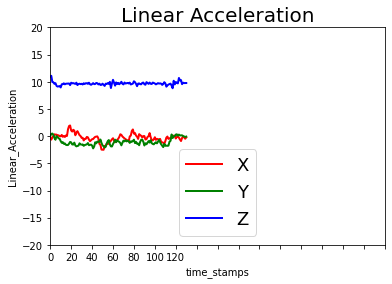

In [6]:
num=4
data_dir = folders_norm[num]
df=pd.read_csv(data_dir)
linear_acceleration = pd.DataFrame()
for i in range(len(df)):
    x=df["x.2"][i]
    y=df["y.2"][i]
    z=df["z.2"][i]
    la=np.array([x,y,z])
    la_df=pd.DataFrame(la.reshape(1,3))
    la_df.index=[str(i)]
    linear_acceleration=linear_acceleration.append(la_df)
linear_acceleration.columns=["X","Y","Z"]
plt.plot(linear_acceleration["X"],label="X",linewidth=2,color="red")
plt.plot(linear_acceleration["Y"],label="Y",linewidth=2, color="green")
plt.plot(linear_acceleration["Z"],label="Z",linewidth=2, color="blue")
plt.xlim=(0,340)
plt.axis([0,len(linear_acceleration),-20,20])
plt.legend(loc='lower center',fontsize=18)
plt.xticks(np.arange(0,340 , step=20))
plt.title("Linear Acceleration",fontsize=20)
#plt.axvspan(0,60,facecolor='r', alpha=0.5)
plt.ylabel("Linear_Acceleration")
plt.xlabel("time_stamps");

In the following cell we can visualize the angular velocity in different bag files by changing the "n" and data_dir variables

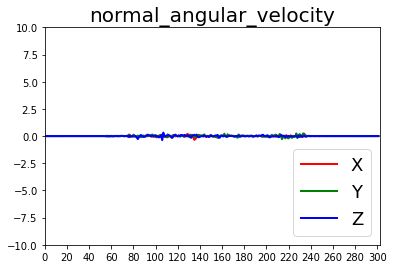

In [7]:
n=0

data_dir = folders_norm[n]
df=pd.read_csv(data_dir)
#print(df.columns)
angular_velocity = pd.DataFrame()
for i in range(len(df)):
    x=df["x.1"][i]
    y=df["y.1"][i]
    z=df["z.1"][i]
    av=np.array([x,y,z])
    av_df=pd.DataFrame(av.reshape(1,3))
    av_df.index=[str(i)]
    angular_velocity=angular_velocity.append(av_df)
    
angular_velocity.columns=["X","Y","Z"]
# fig=plt.figure(figsize=(14,6))
plt.axis([0,len(df),-10,10])

plt.plot(angular_velocity["X"],label="X",linewidth=2,color="red")
plt.plot(angular_velocity["Y"],label="Y",linewidth=2, color="green")
plt.plot(angular_velocity["Z"],label="Z",linewidth=2, color="blue")
plt.legend(loc='lower right',fontsize=18)
plt.title("normal_angular_velocity",fontsize=20)
plt.xticks(np.arange(0,len(angular_velocity) , step=20));

---
###**NOTE**
#### **normal_0** is used to find the **threshold** of errors and **normal_5** is used to **evaluate** the model, so we do not include them in the training set.

---

### **3. DATASET PREPARATION**
###3.1 Importing Normal and Abnormal IMU Data

In [0]:
'''Below we have the code to create the training set, we are going to loop through the normal-1, normal-2,
normal-3, normal-4 and create a dataframe called imu_norm_6 which contains six dimensional IMU vectors whose 
first three elements correspond to the angular velocity in the x,y,z direction and the last three correspond
to the linear acceleration in the three direction
'''
imu_norm_6 = pd.DataFrame()                            
for num in [1,2,3,4]:                                   
    data_dir = folders_norm[num]
    df=pd.read_csv(data_dir)

    for i in range(len(df)):
       
        xa=df["x.1"][i]
        ya=df["y.1"][i]
        za=df["z.1"][i]
        xl=df["x.2"][i]
        yl=df["y.2"][i]
        zl=df["z.2"][i]-10  # we reduce "10" from the linear_acceleration in the z-direction to bring all values around zero-a preprocessing step
        
        imu=np.array([xa,ya,za,xl,yl,zl])
        imu_df=pd.DataFrame(imu.reshape(1,len(imu)))
        imu_df.index=[str(i)]
        imu_norm_6=imu_norm_6.append(imu_df)
        
imu_norm_6.columns=["XA","YA","ZA","XL","YL","ZL"]


### 3.3 Data Preprocessing
---
### Raw Training set Dataframe - imu_norm_6

### Preprocessed Training set Dataframe - imu_norm_6_s

---

In [13]:
imu_norm_6.head()

,XA,YA,ZA,XL,YL,ZL
0,0.027669,0.008776,0.008341,-0.362846,0.549172,-0.124703
1,-0.033511,0.012216,-0.000151,0.009807,0.441299,-0.389483
2,0.012266,-0.007867,-0.003631,-0.264780,0.137293,-0.212963
3,0.061616,-0.013745,-0.007604,-0.254973,0.294200,-0.242383
4,0.037237,0.046223,0.023627,0.019613,0.647239,-0.477743


In [0]:
''' for preprocessing we just scale all the 6 features in our dataset into the range (-1 to 1)
using the MinMaxScaler from sklearn library and then we create a scaled version of the training dataset
named as imu_norm_6_s where the _s represents the scaled version
'''
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(imu_norm_6)
imu_norm_6_s=pd.DataFrame(scaler.transform(imu_norm_6))

In [15]:
imu_norm_6_s.head()


,0,1,2,3,4,5
0,0.251706,0.029385,0.181397,-0.070524,0.400000,-0.217910
1,0.132675,0.038066,0.159944,0.066908,0.357692,-0.379104
2,0.221738,-0.012623,0.151153,-0.034358,0.238462,-0.271642
3,0.317750,-0.027461,0.141116,-0.030741,0.300000,-0.289552
4,0.270320,0.123902,0.220013,0.070524,0.438462,-0.432836


imu_norm_6_s: (551, 6)

#**LSTM_AUTOENCOER**

###1. Creating X_train and Y_train

In [0]:
''' here we take the imu_norm_s and create our x_train and y_train suitable to our model
the model is created such as to reconstruct three consecutive vectors, so a
window of length 3 slides through the sequence and it is appended to the x_train array
''' 
z=np.array(imu_norm_6_s)
look_back=3
x_train=[]
y_train=[]

for i in range(len(z)-look_back+1):
    temp=[]
    for j in range(look_back):
        temp.append(z[i+j])
    x_train.append(temp)
  
x_train=np.array(x_train)

y_train=x_train # note that in an autoencoder the input and the output will be the same

# print("x_train: ",x_train.shape)
# print("y_train: ",y_train.shape)

x_train:  (549, 3, 6)

y_train:  (549, 3, 6)

###2. MODEL BUILDING
---
Further details regarding this model is provided in the Report

---

In [0]:
time_step=look_back #=3
n_features=6
model=Sequential()
model.add(LSTM(128,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
model.add(LSTM(64,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=False))
model.add(RepeatVector(time_step))
model.add(LSTM(64,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
model.add(LSTM(128,activation="tanh",batch_input_shape=(None,time_step,n_features),return_sequences=True))
model.add(TimeDistributed(Dense(n_features,activation="sigmoid")))
model.summary()
# plot_model(model, to_file='Submission_LSTM_autoencoder.png', show_shapes=True,show_layer_names=False)
model.compile(optimizer=optimizers.adam(lr=0.01),loss="mse")
# model.fit(x_train,y_train,epochs=500) # uncomment this to train the model again
# model.save("/content/drive/My Drive/SP CUP 2020/IMU/Submission_LSTM_autoencoder.hdf5")



---
Loading the already trained and saved model

---

In [0]:
''' in the load model the path to the Submission_LSTM_autoencoder.hdf5 must be specified
'''
model=load_model("/content/drive/My Drive/SP CUP 2020/IMU/Submission_LSTM_autoencoder.hdf5");
plot_model(model, to_file='Submission_LSTM_autoencoder.png', show_shapes=True,show_layer_names=False,dpi=80);


### 3. THRESHOLD FINDING
---
As described under **NOTE** normal-0 is used to find the threshold of a-error and l-error-.Please refer to the report for detais about a-error and l-error

---

### 3.1 Finding a_error and l_error in the normal-0

In [0]:
''' here we prepare x_train and y_train for the data in normal-0 named 
x_thresh and y_thresh here, use the model trained above to find the reconstruction error
using the Mean Absolute Error.
a-error and l-error are found separately so that in the next task, we can find a threshold for these
values so that they can used to classify the timestamps as normal or abnormal
'''
numb=0
x_t= pd.DataFrame()
for num in [numb]:
    data_dir = folders_norm[num]
    df=pd.read_csv(data_dir)
    for i in range(len(df)):
       
        xa=df["x.1"][i]
        ya=df["y.1"][i]
        za=df["z.1"][i]
        xl=df["x.2"][i]
        yl=df["y.2"][i]
        zl=df["z.2"][i]-10
        
        imu=np.array([xa,ya,za,xl,yl,zl])
        imu_df=pd.DataFrame(imu.reshape(1,len(imu)))
        imu_df.index=[str(i)]
        x_t=x_t.append(imu_df)
      
x_t.columns=["XA","YA","ZA","XL","YL","ZL"]
x_t_s=pd.DataFrame(scaler.transform(x_t))

x_t.describe()
z=np.array(x_t_s)
look_back=3
x_thresh=[]
y_thresh=[]

for i in range(len(z)-look_back+1):
    temp=[]
    for j in range(look_back):
        temp.append(z[i+j])
    x_thresh.append(temp)
  
x_thresh=np.array(x_thresh)

y_thresh=x_thresh

# print("x_thresh: ",x_thresh.shape)
# print("y_test: ",y_thresh.shape)

x_pred = model.predict(x_thresh)  # here we recontruct all the x_thresh

a_error=[]
l_error=[]
for i in range(len(x_thresh)):
    mean_error_in_three_timesteps=np.mean(np.abs(x_pred[i]-y_thresh[i]),axis=0)# here we find the MAE in the three timesteps, this is the error vector with dimension 6
    a=np.mean(np.abs(mean_error_in_three_timesteps[:3]),axis=0) # we find the MAE in the angular velocity in the three directions 
    l=np.mean(np.abs(mean_error_in_three_timesteps[3:]),axis=0)# we find the MAE in the linear acceleration in the three direction
    a_error.append(a)
    l_error.append(l)                                                            # we find these errors separately so that we can know which sensor led to the abnormality                                               
    

a_error=np.array(a_error)
l_error=np.array(l_error)
   

# print("a_error ",a_error.shape)
# print("l_error ",l_error.shape)

x_test:  (300, 3, 6)

y_test:  (300, 3, 6)

a_error  (300,)

l_error  (300,)

###3.2 Defined below is the get_best_distribution functions for fitting the perfectstatistical distribution on a-error and l-error

In [0]:

import warnings
warnings.filterwarnings('ignore')
import io
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme","beta","betaprime","bradford","burr","burr12","cauchy","chi","chi2","cosine","dgamma","alpha",
                  "dweibull","erlang","expon","exponweib","exponpow","fatiguelife","fisk",
                  "cauchy","foldnorm","f","genlogistic","gamma","genpareto","genexpon","genextreme",
                  "gengamma","genhalflogistic","gennorm","gilbrat","gompertz","gumbel_r",
                  "gumbel_l","halfcauchy","halfnorm","halflogistic","hypsecant","gausshyper","invgamma","invgauss",
                  "invweibull","johnsonsb","ksone","kstwobign","levy_l",
                  "levy","loglaplace","loggamma","lognorm","maxwell","mielke",
                  "nakagami","ncx2","pareto","lomax","powernorm",
                  "powerlaw","rdist","rayleigh","rice","recipinvgauss","semicircular",
                  "t","trapz","triang","truncexpon","truncnorm",
                  "tukeylambda","vonmises","uniform","wald","weibull_max","weibull_min","logistic","nct","norminvgauss","johnsonsu"]#,"johnsonsu"

    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        #print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    # print("Best fitting distribution: "+str(best_dist))
    # print("Best p value: "+ str(best_p))
    # print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

%matplotlib inline


matplotlib.rcParams['figure.figsize'] = (16.0, 14.0)
matplotlib.style.use('ggplot')

'''This function can be used to plot the histogram of the a-error and l-error and the original distribution on the same figure'''
def Plot(data,dist):
    bins = 100
    size = 16384
    DISTRIBUTIONS = [dist]
    plotData = []
    for distribution in DISTRIBUTIONS:
        # Create random data
        rv = pd.Series(data)
        # Get sane start and end points of distribution
        start = distribution.ppf(0)
        end = distribution.ppf(0.99)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = distribution.pdf(x)
        pdf = pd.Series(y, x)

        # Get histogram of random data
        b = np.linspace(start, end, bins+1)
        y, x = np.histogram(rv, bins=b, normed=True)
        x = [(a+x[i+1])/2.0 for i,a in enumerate(x[0:-1])]
        hist = pd.Series(y, x)

        # Create distribution name and parameter string
        title = '{}({})'.format(distribution.dist.name, ', '.join(['{}={:0.2f}'.format(k,v) for k,v in distribution.kwds.items()]))

        # Store data for later
        plotData.append({
        'pdf': pdf,
        'hist': hist,
        'title': title
        })


        plotMax = len(plotData)

    for i, data in enumerate(plotData):
        w = abs(abs(data['hist'].index[0]) - abs(data['hist'].index[1]))

        # Display
        plt.figure(figsize=(10, 6))
        ax = data['pdf'].plot(kind='line', label='Model PDF', legend=True, lw=2)
        ax.bar(data['hist'].index, data['hist'].values, label='Random Sample', width=w, align='center', alpha=0.5)
        ax.set_title(data['title'])
        plt.savefig("linear_acceleration_reconstruction_error")



### 3.21 Finding the threshold for a-error ->tang(takes some time)

In [28]:
'''this function is going to return the best distribution and the parameters for the distribution, we need to
copy and paste both to the next cell's "valid" variable
'''
d=a_error
get_best_distribution(d)


('fatiguelife',
 6.930775052716663e-07,
 (2.053607199072348, 0.022963572626635686, 0.01900377655327603))

In [29]:
'''from the output of the above cell, the name of the distribution and the parameters are used in the valid variable,
to find the threshold using stats."name_of_distribution"(parameters)
'''
valid = stats.fatiguelife(2.053607199072348, 0.022963572626635686, 0.01900377655327603)
# Plot(d,valid) # this is to plot the histogram of the data along with the fitted distribution
threshold=valid.ppf(0.95)
tang=threshold
print(threshold)

0.2763809324335767


### 3.22 Finding the threshold for l-error ->tlin(takes some time)

In [30]:
'''this function is going to return the best distribution and the parameters for the distribution, we need to
copy and paste both to the next cell's "valid" variable
'''
d=l_error
get_best_distribution(d)


('johnsonsu',
 0.0007865842873056234,
 (-0.8966901568949843,
  0.4457298938858065,
  0.16624892034896624,
  0.0024331917358663586))

In [32]:
'''from the output of the above cell, the name of the distribution and the parameters are used in the valid variable,
to find the threshold using stats."name_of_distribution"(parameters)
'''
valid = stats.johnsonsu(-0.8966901568949843,
  0.4457298938858065,
  0.16624892034896624,
  0.0024331917358663586)
# Plot(d,valid) # this is to plot the histogram of the data along with the fitted distribution
threshold=valid.ppf(0.95)
tlin=threshold
print(threshold)

0.5305670351209596


Note that when using the lstm autoencoder model,"Submission_LSTM_autoencoder.hdf5" submitted to the competition, we will receive the same threshold below.
If the organizers wish to retrain the models and check, due to random initializations of the weights, the distribution of the errors might change slightly, due to which the exact same threshold values will not be obtained.

In [0]:
tang=0.2763809324335767
tlin=0.5305670351209596

###4. Model Evaluation

###4.1 Evaluating the model on the normal bags
---

Finding the accuracy of the model on the normal-5 bag file which was used neither in the training nor in the threshold finding

---
Since a ground truth at each timestamp was not given in the competition, to evaluate our model, we check how good the model predictions are on the normal bag, by changing the "normal_bag" variable we can check the accuracy using the following equation:

accuracy=(no of timestamps classified as "normal")/(total number of timestamps in the normal bag)

---


In [37]:
imu_norm_test = pd.DataFrame()
normal_bag=5
for num in [normal_bag]:
    data_dir = folders_norm[num]
    df=pd.read_csv(data_dir)
    imu_norm_test=df[["x.1","y.1","z.1","x.2","y.2","z.2"]]
    imu_norm_test["z.2"]=imu_norm_test["z.2"] -10
    imu_norm_test.columns=["XA","YA","ZA","XL","YL","ZL"]
    # print(imu_norm_test)
   
ab=scaler.transform(imu_norm_test)
imu_norm_test_s=pd.DataFrame(ab,columns=["XA","YA","ZA","XL","YL","ZL"])
zt=np.array(imu_norm_test_s)

x_test=[]
y_test=[]

for i in range(len(zt)-look_back+1):
    temp=[]
    for j in range(look_back):
        temp.append(zt[i+j])
    x_test.append(temp)

x_test=np.array(x_test)

''' In the code below, we compare the reconstructed input with the original input, both 2 dimensional arrays (3 x 6), and get the MAE(mean absolute error), then
we again take the mean absolute error of the three timesteps forming an error vector with dimensions (6x1), the MAE in the first three elements of this error vector 
is referred as a-error(error in angular velocity) and the MAE in the last three elements is referred as l-error(error in the linear_acceleration).
'''

print(x_test.shape)
error_count=0
total_count=len(x_test)
for i in range(len(x_test)):
    temp=x_test[i].reshape(1,3,6)
    pred=model.predict(temp)
    temp=temp.reshape(3,6)
    pred=pred.reshape(3,6)
    error_vector=np.mean(np.abs(temp-pred),axis=0)
    a=np.mean(np.abs(error_vector[:3]),axis=0)
    l=np.mean(np.abs(error_vector[3:]),axis=0)
    # print(error_vector)
    # print(l)
    if a>tang or l>=tlin:
        # print("yes")
        error_count=error_count+1
print(tang,tlin)
print("recall",(total_count-error_count)/total_count)
    

(140, 3, 6)
0.2763809324335767 0.5305670351209596
recall 0.8928571428571429


---
Note that in the normal bag all the timstamps are normal and in the abnormal bag there are abnormal and normal timestamps as well, since the ground truth for the abnormal bag was not provided we come up with our own groundtruth.The method in which the timestamps in the abnormal bag was annotated is described in the report.

---

###4.2 Evaluating the model on the abnormal bags
---
At a particular timestamp in the abnormal bag, the angular acceleration can be abnormal, the linear_acceleration can be abnormal or both or None(normal timestamp). When coming up with the ground truth, we obtain two ground truth separately for the angular velocity and the linear acceleration.

---

### 4.2.1 GROUND TRUTH FOR LINEAR ACCELERATION

In [0]:
Truthl=[[None],[None],[None],[None],[None],[None]]
Truthl[0]=['A', 'A', 'A', 'A', 'A','N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N','N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A','A', 'A', 'A', 'A', 'A', 'A', 'A']
Truthl[1]=['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A',
       'N', 'A', 'A', 'A', 'N', 'A', 'A', 'N', 'N', 'A', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'N',
       'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'A', 'N', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'N']
Truthl[2]=['N', 'N', 'N', 'N', 'N', 'A', 'N', 'A', 'A', 'A', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N',
       'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N',
       'N', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N',
       'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N',
       'N']
Truthl[3]=['N', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'N',
       'A', 'A', 'A', 'N', 'N', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'N', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A',
       'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'N',
       'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N']
Truthl[4]=['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N',
       'A', 'A', 'A', 'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A']
Truthl[5]=['N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'N',
       'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A']


###4.2.2 GROUND TRUTH FOR ANGULAR VELOCTY

In [0]:
Trutha=[[None],[None],[None],[None],[None],[None]]
Trutha[0]=['A', 'A', 'A', 'A', 'A','N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'N', 'A', 'A', 'A', 'A']
Trutha[1]=['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A',
       'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'A', 'A',
       'A', 'A', 'A', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'A',
       'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
Trutha[2]=['N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A',
       'N', 'A', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'N',
       'N', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'N', 'N', 'N',
       'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'N',
       'N']

Trutha[3]=['A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'N', 'N', 'A', 'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N']
Trutha[4]=['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'N', 'A', 'A', 'N', 'N', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'N', 'N',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'A', 'N', 'A',
       'N', 'N', 'N', 'N', 'N', 'N']
 
Trutha[5]=['N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'A', 'A', 'A', 'N',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'N']

---
while evaluating  on the abnormal bag, a timestamp is considered to be abnormal if either the angular velocity or the linear acceleration or both are predicted as abnormal.

---

In [0]:
imu_abnorm_test = pd.DataFrame()
for numb in [0]:
    truthl=Truthl[numb]
    trutha=Trutha[numb]
    data_dir_ab = folders_abnorm[numb]
    df_ab=pd.read_csv(data_dir_ab)
    imu_abnorm_test=df_ab[["x.1","y.1","z.1","x.2","y.2","z.2"]]
    imu_abnorm_test["z.2"]=imu_abnorm_test["z.2"] -10
    imu_abnorm_test.columns=["XA","YA","ZA","XL","YL","ZL"]
    # print(imu_norm_test)
print(tang,tlin)  
ab=scaler.transform(imu_abnorm_test)
imu_abnorm_test_s=pd.DataFrame(ab,columns=["XA","YA","ZA","XL","YL","ZL"])
zt_ab=np.array(imu_abnorm_test_s)
print(zt_ab.shape)

x_test_ab=[]
y_test_ab=[]

for i in range(len(zt_ab)-look_back+1):
    temp=[]
    for j in range(look_back):
        temp.append(zt_ab[i+j])
    x_test_ab.append(temp)

x_test_ab=np.array(x_test_ab)

print(x_test_ab.shape)
# error_count=0
# total_count=len(x_test)
tp=0
tn=0
fp=0
fn=0

for i in range(len(x_test_ab)):
    temp=x_test_ab[i].reshape(1,3,6)
    pred=model.predict(temp)
    temp=temp.reshape(3,6)
    pred=pred.reshape(3,6)
    error_vector=np.mean(np.abs(temp-pred),axis=0)
    a=np.mean(np.abs(error_vector[:3]),axis=0)
    l=np.mean(np.abs(error_vector[3:]),axis=0)
    
#     # print(error_vector)
    # print(l)
    # print(a,l,trutha[2+i],truthl[2+i])
    if (l>=tlin or a>=tang) and (truthl[2+i]=="A" or trutha[2+i]=="A"):
        tp+=1
            
    if (l>=tlin or a>=tang) and (truthl[2+i]=="N" and trutha[2+i]=="N"):
        fp+=1
    if (l<=tlin and a<=tang) and (truthl[2+i]=="A" or trutha[2+i]=="A") :
        fn+=1
        print(a,l,trutha[2+i],truthl[2+i])
    if (l<=tlin and a<=tang) and (truthl[2+i]=="N" and truthl[2+i]=="N") :
        tn+=1
# print("tp: ",tp,"\n","fp: ",fp,"\n","tn: ",tn,"\n","fn: ",fn)
  
precision=round(tp/(tp+fp),2) 
recall= round(tp/(tp+fn),2)
F1_score= round((2*precision*recall)/(precision+recall),2)

print('Precision: ',precision)

print('Recall: ',recall)

print('F1_Score: ',F1_score)


0.014663427659498292 0.01953747603025051
(38, 6)
(36, 3, 6)
Precision:  0.92
Recall:  1.0
F1_Score:  0.96


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
